In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import math

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

**Adicionar fashion_mnist, horses_or_humans, mnist**

In [4]:
url_cat_dog = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
url_flower = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_cat = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url_cat_dog, extract=True)
zip_flw = tf.keras.utils.get_file('flower_photos.tar', origin=url_flower, extract=True)

path_cat = os.path.join(os.path.dirname(zip_cat), 'cats_and_dogs_filtered')
path_flw = os.path.join(os.path.dirname(zip_flw), 'flower_photos')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [6]:
train_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'train'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'validation'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

train_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="training", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="validation", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
cat_class_names = train_cat.class_names
flw_class_names = train_flw.class_names

# Viz

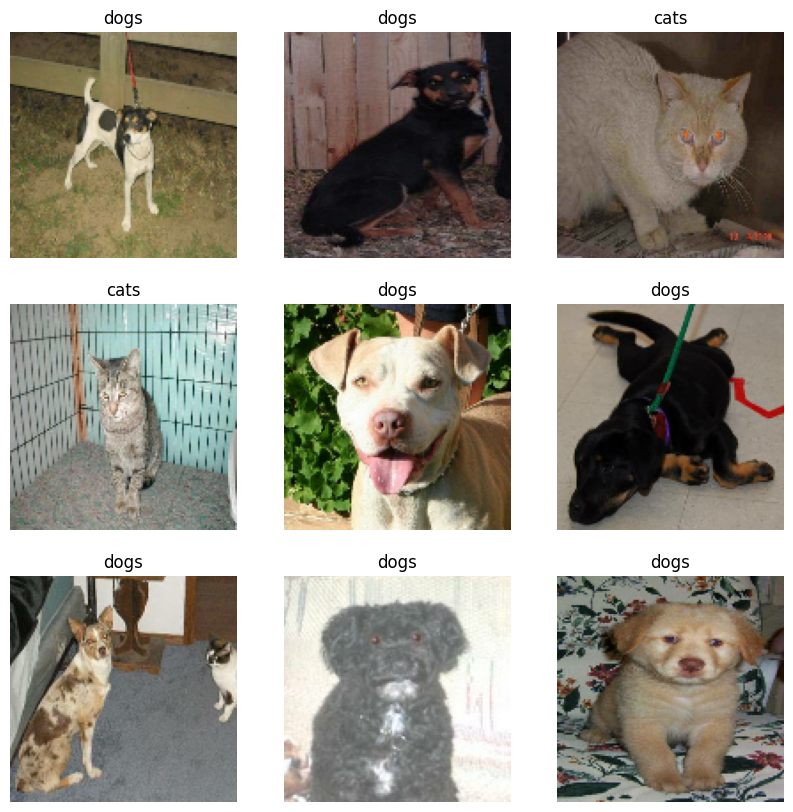

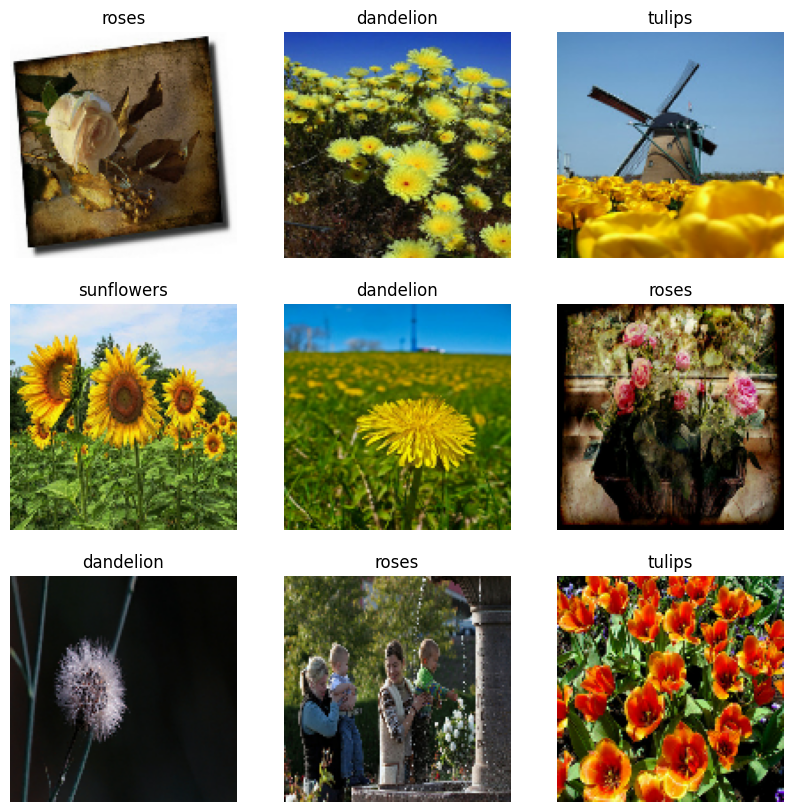

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_cat.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cat_class_names[labels[i]])
        plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_flw.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flw_class_names[labels[i]])
        plt.axis("off")

# Preprocessing

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

cat_train_ds = train_cat.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cat_valid_ds = valid_cat.cache().prefetch(buffer_size=AUTOTUNE)

flw_train_ds = train_flw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
flw_valid_ds = valid_flw.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [9]:
def generate_model(num_classes):
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ])
    return Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

In [10]:
def print_performance(title, history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    print(title, 'acc:', acc[-1], 'val_acc:', val_acc[-1])

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [21]:
def print_filters_1d(filters):
    depth = filters.shape[-1]
    size = math.ceil(math.sqrt(depth))
    
    if depth < (size*size):
        filters = np.resize(filters, (size*size))
    
    fig, axarr = plt.subplots(1,1, figsize=(size/4, size/4))
    axarr.axis('off')
    axarr.imshow(np.reshape(filters, (size, size)))
    fig.suptitle(filters.shape, fontsize=8)
    
def print_filters_3d(filters):
    depth = filters.shape[-1]
    mj = 16
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    if mi == 1:
        for j in range(mj):
            axarr[j].axis('off')
            if fi < depth:
                axarr[j].imshow(filters[:,:,fi])
            fi += 1
    else:
        for i in range(mi):
            for j in range(mj):
                axarr[i][j].axis('off')
                if fi < depth:
                    axarr[i][j].imshow(filters[:,:,fi])
                fi += 1
    fig.suptitle(filters.shape, fontsize=8)

In [12]:
def get_mean_output(model, dataset, neuron_layers):
    means = {}
    deviations = {}
    for l in neuron_layers:
        means[l] = None
        deviations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if means[l] is None:
                        means[l] = np.copy(out)
                    else:
                        means[l] += out
        f.value += 1

    for l in neuron_layers:
        means[l] = means[l] / len(dataset)
    print('Mean calculated')
        
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if deviations[l] is None:
                        deviations[l] = (out - means[l])**2
                    else:
                        deviations[l] += (out - means[l])**2
        f.value += 1
    
    for l in neuron_layers:
        deviations[l] = np.sqrt(deviations[l] / len(dataset))
    print('Std dev calculated')
    
    return means, deviations

# Training T1, T2

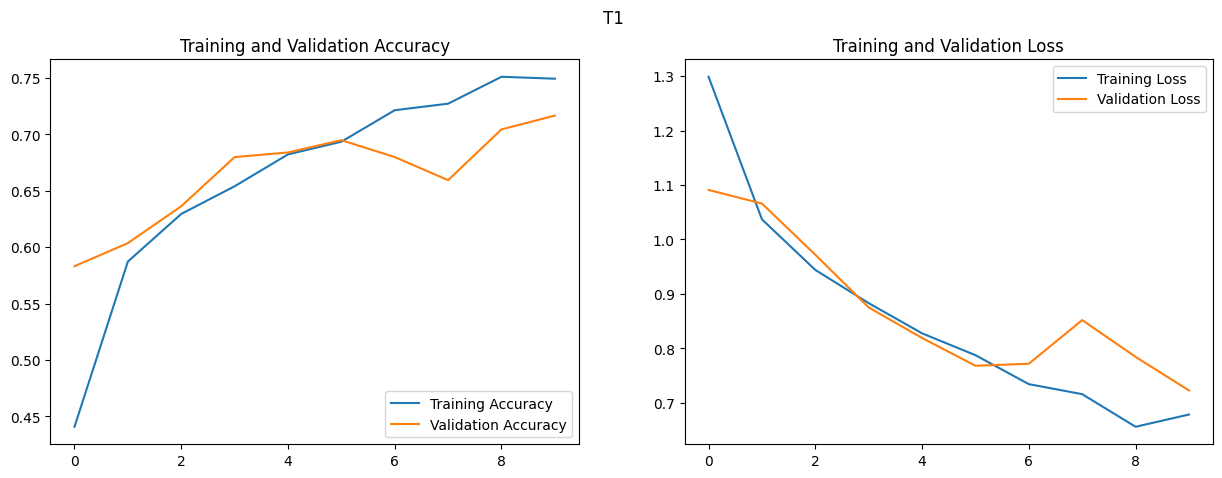

CPU times: total: 12min 39s
Wall time: 3min 41s


In [15]:
%%time
epochs=10
model = generate_model(len(flw_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

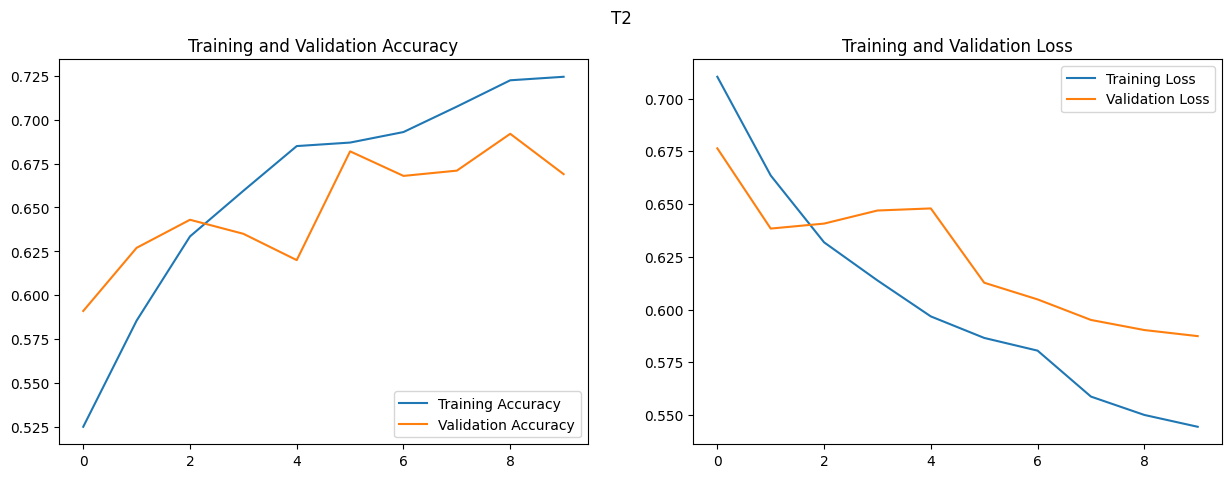

CPU times: total: 9min 5s
Wall time: 2min 38s


In [18]:
%%time
epochs=10
model = generate_model(len(cat_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model.fit(train_cat, validation_data=valid_cat, epochs=epochs, verbose=0)
print_performance('T2', historyt1, epochs)

# Join datasets Y

In [13]:
total_label = len(flw_class_names) + len(cat_class_names)
diff_flw = total_label - len(flw_class_names)
diff_cat = total_label - len(cat_class_names)

In [14]:
train_cat_join = train_cat.map(lambda x, y: (x, y + diff_cat))
valid_cat_join = valid_cat.map(lambda x, y: (x, y + diff_cat))

# Training T1 -> T2

T1 acc: 0.738760232925415 val_acc: 0.6975476741790771


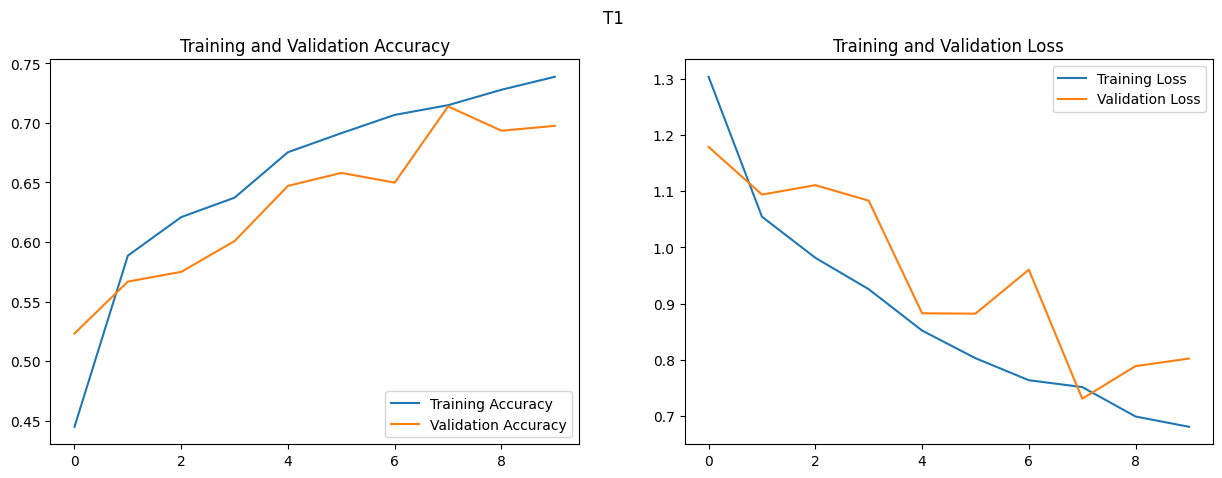

CPU times: total: 12min 51s
Wall time: 3min 47s


In [53]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

32/32 [==============================] - 2s 56ms/step - loss: 9.9780 - accuracy: 0.0000e+00
Pre Train:
T1 loss: 0.8020702004432678 acc: 0.6975476741790771
T2 loss: 9.977991104125977 acc: 0.0
32/32 [==============================] - 2s 57ms/step - loss: 0.5769 - accuracy: 0.6920
Post Train:
T1 loss: 20.04341697692871 acc: 0.0
T2 loss: 0.5768507122993469 acc: 0.6919999718666077
T2 acc: 0.703000009059906 val_acc: 0.6919999718666077


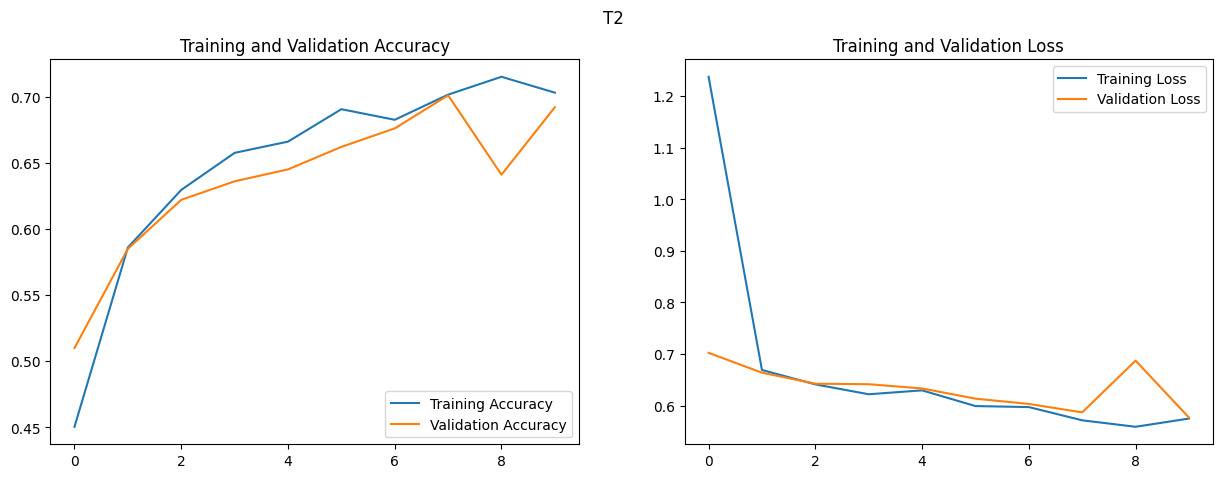

CPU times: total: 9min 25s
Wall time: 2min 41s


In [59]:
%%time

losst1, acct1 = model.evaluate(valid_flw)
losst2, acct2 = model.evaluate(valid_cat_join)
print('Pre Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)
print('T2', 'acc:', acct2, 'loss:', losst2)

epochs=10
historyt2 = model.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

losst1, acct1 = model.evaluate(valid_flw)
print('Post Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)

print_performance('T2', historyt2, epochs)

# Sleep

In [15]:
neuron_layers = [2,4,6,10,11]

In [16]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)

CPU times: total: 12min 39s
Wall time: 3min 44s


In [95]:
%%time
epochs=10
model2 = generate_model(total_label)
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model2.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 9min
Wall time: 2min 42s


In [18]:
meanst1, deviationst1 = get_mean_output(model, train_flw, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


In [19]:
meanst2, deviationst2 = get_mean_output(model2, train_cat_join, neuron_layers)

IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [91]:
%%time
model3 = generate_model(total_label)
opti_fn = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history3 = sleep_training(model3, opti_fn, loss_fn, train_cat_join, 10)

CPU times: total: 9min 40s
Wall time: 3min 22s


In [92]:
custom_evaluate(model3, loss_fn, valid_cat_join)

(0.5436602, 0.727)

In [90]:
model2.evaluate(train_cat_join)

63/63 [==============================] - 4s 57ms/step - loss: 0.5063 - accuracy: 0.7415


[0.5062776803970337, 0.7415000200271606]

In [98]:
%%time
epochs=10
model4 = generate_model(total_label)
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt4 = model4.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0, callbacks=[CustomCallback()])

0
1
2
3
4
5
6
7
8
9
CPU times: total: 8min 46s
Wall time: 2min 30s


In [97]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        print(self.model)

In [88]:
def custom_evaluate(model, loss, ds_validation):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
    for x, y in ds_validation:
        logits = model(x, training=True)
        loss_value = loss(y, logits)
        
        loss_avg.update_state(loss_value)
        accuracy.update_state(y, logits)
        
    return loss_avg.result().numpy(), accuracy.result().numpy()
                
def custom_training(model, optimizer, loss, ds_train, num_epochs):
    train_loss_results = []
    train_accuracy_results = []
    
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in ds_train:
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                loss_value = loss(y, logits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y, logits)
        
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

    return {'loss': train_loss_results, 'accuracy': train_accuracy_results}

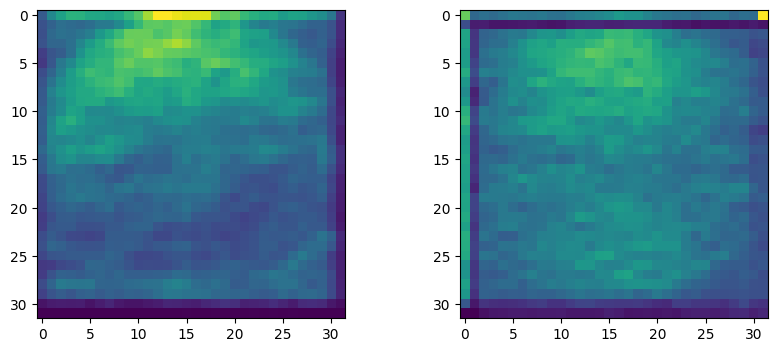

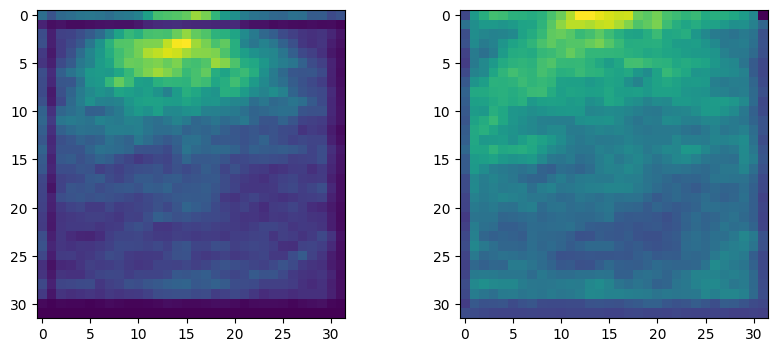

In [50]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
mat1 = meanst1[6][0][:,:,1]
mat2 = meanst2[6][0][:,:,1]
axarr[0].imshow(mat1)
axarr[1].imshow(mat2)
plt.show()
multpld_mat = np.multiply(mat1, mat2) # element-wise multiplication
divided_mat = mat1 - mat2
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].imshow(multpld_mat)
axarr[1].imshow(divided_mat)
plt.show()

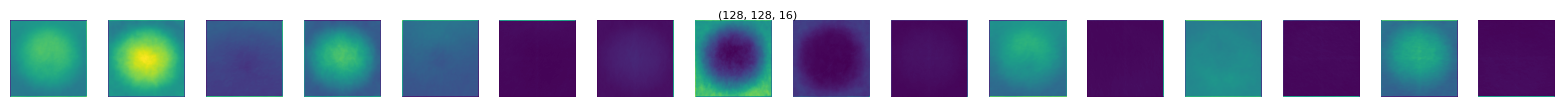

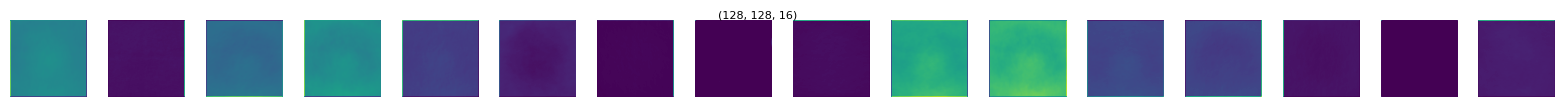

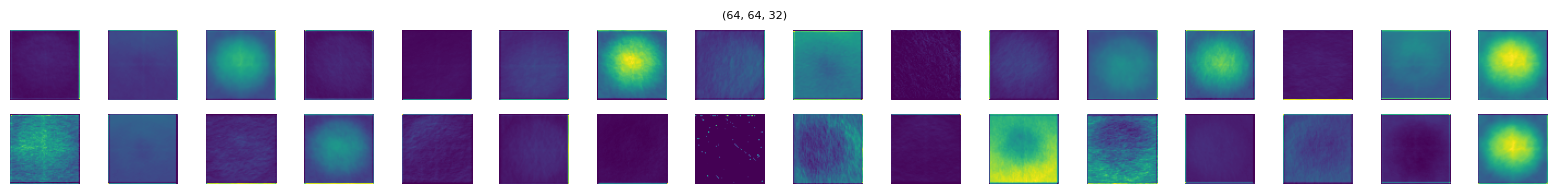

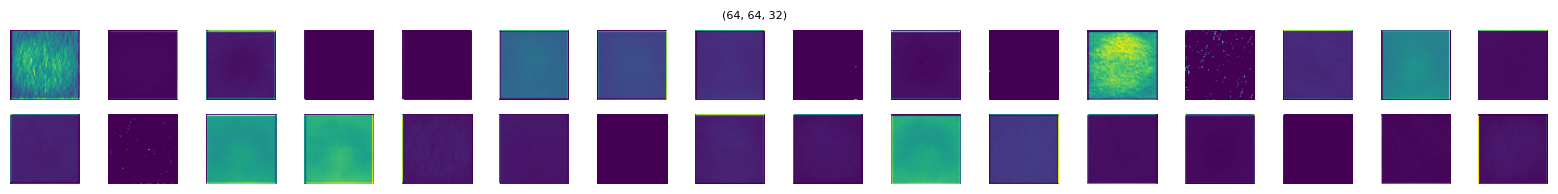

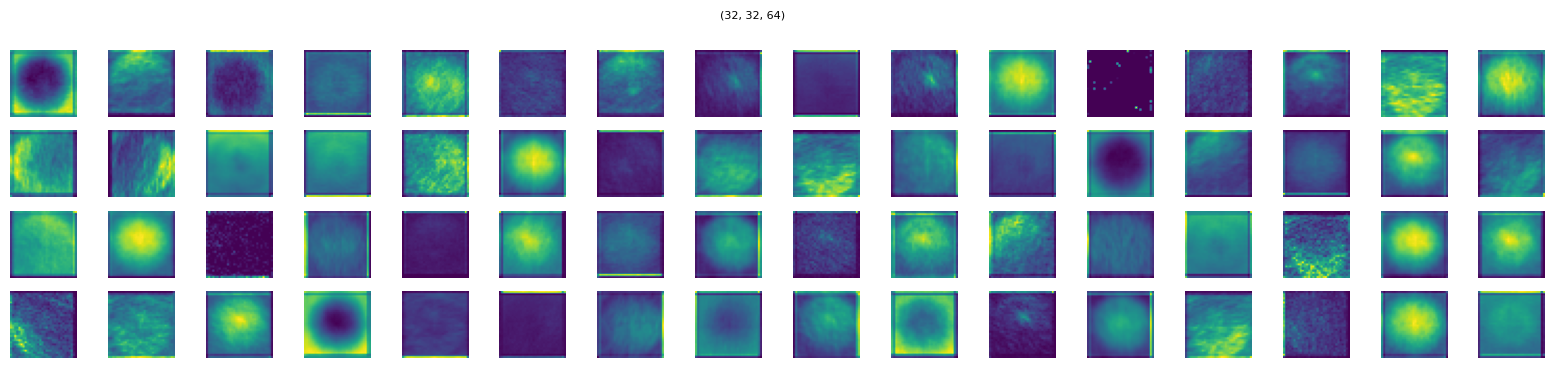

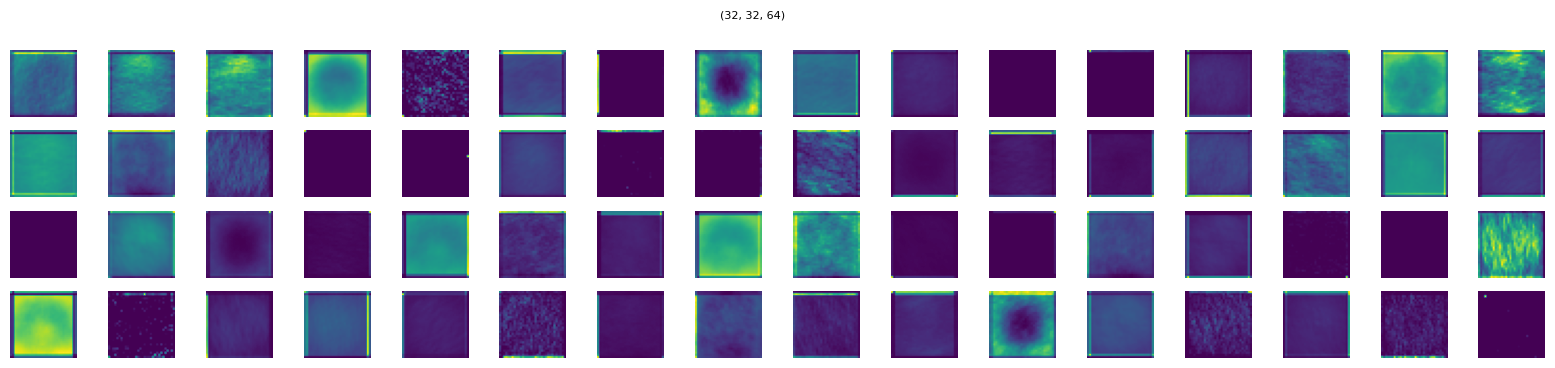

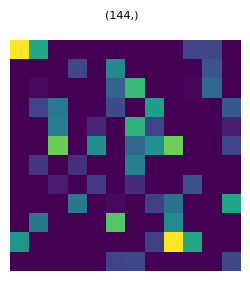

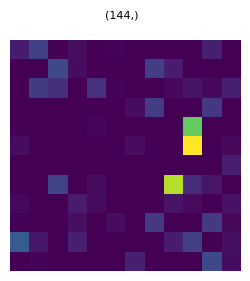

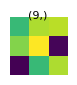

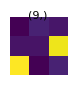

In [22]:
for l in neuron_layers:
    ftrs = meanst1[l][0]
    ftrs2 = meanst2[l][0]
    
    if len(ftrs.shape) == 1:
        print_filters_1d(ftrs)
        print_filters_1d(ftrs2)
    elif len(ftrs.shape) == 3:
        print_filters_3d(ftrs)
        print_filters_3d(ftrs2)